# Tesla Gigafactory in Brandenburg 

### Eine Untersuchung der Einstellung der Anwohner auf Grundlage der Sentiment Analyse von Twitter Daten

##### Vladimir Burlay

### Inhalt 
* Bibliotheken und Einstellungen
* Datenzuordnung und Aufbereitung
  + Datensammulung über die Twitter-API
  + Datenaufbereitung: Delete Hashtags, URL, Benutzername
  + Text-Manipulation
     + Cleansing Data (Fehlerkorrektur im Text)
     + Stopwords Removal
     + Vektor-Darstellung 
* Classificationsmodell(Regression) 

In [2]:
library("twitteR")
library("ROAuth")
library("modest")
library("httr")
library("tidyverse")
library("lubridate")
library("twitteR")
library("modest")
library("httr")
library("tidyverse")
library("NLP")
library("tm")
library("stringr")
library("RCurl")
library("base64enc")
library("ggplot2")
library("wordcloud2")

In [ ]:
#Workspace und Grafik löschen

In [3]:
rm(list=ls()) 
graphics.off() 

In [ ]:
#Wortschätzen mit positiven(hu.liu.pos) und negativen(hu.liu.neg) Wörter 

In [4]:
setwd('XXXXXXXXXXXXXXXXXXX')
projectDir = getwd()

dataDir = file.path(projectDir, 'data')
codeDir = file.path(projectDir, 'R')

hu.liu.pos = scan(file.path(dataDir, 'opinion-lexicon-English', 'positive-words.txt'), what='character', comment.char=';')
hu.liu.neg = scan(file.path(dataDir, 'opinion-lexicon-English', 'negative-words.txt'), what='character', comment.char=';')


In [5]:
# Einige Wörter zu Wortschätz hinzufügen 
pos.words = c(hu.liu.pos, 'upgrade')
neg.words = c(hu.liu.neg, 'wtf', 'wait', 'waiting', 'epicfail', 'mechanical')

In [ ]:
# Twitter API

In [6]:
appname <- "Tesla_Deutschland"
requestURL <- "https://api.twitter.com/oauth/request_token"
accessURL <- "http://api.twitter.com/oauth/request_token"
authURL <- "https://api.twitter.com/oauth/authorize"
consumerKey <- "XXXXXXXXXXXXXXXXXXXXXXXXXXXX"
consumerSecret <- "XXXXXXXXXXXXXXXXXXXXX"
accessToken = "XXXXXXXXXXXXXXXXXXXXXXXX"
accessSecret = "XXXXXXXXXXXXXXXXXXXXXXXXX"

In [7]:
setup_twitter_oauth(consumer_key = consumerKey,
                    consumer_secret = consumerSecret,
                    access_token = accessToken,
                    access_secret = accessSecret)

[1] "Using direct authentication"


Um die Hashtag-Analyse mit R zu demonstrieren, 
wird hier das Hashtag-Schlüsselwort #GigaBerlin Nummer eins für die Studie ausgewählt.
Abgesehen von diesem Suchschlüsselwort erfordert die Funktion searchTwitter ()
auch die maximale Anzahl von Tweets, die der Funktionsaufruf von den Tweets zurückgibt. 
Betrachten wir für diese Diskussion die maximale Anzahl als 1000. 
Abhängig von der Geschwindigkeit Ihres Internets und 
dem Datenverkehr auf dem Twitter-Server erhalten Sie innerhalb
weniger Minuten eine Antwort auf ein R-Listenklassenobjekt und ein R-Listenklassenobjekt

In [8]:
tweets <- searchTwitter("#GigaBerlin" ,lang ="en", n = 1000)
mode(tweets)

Warning message in doRppAPICall("search/tweets", n, params = params, retryOnRateLimit = retryOnRateLimit, :
"1000 tweets were requested but the API can only return 296"


[1] "list"

In [9]:
length(tweets) # Anzahl des Twitts

[1] 296

In [10]:
str(head(tweets,1)) #Der Struktur des Tweets

List of 1
 $ :Reference class 'status' [package "twitteR"] with 17 fields
  ..$ text         : chr "RT @Gf4Tesla: #GigaBerlin \n \nThat the gravel is now delivered almost daily by train, I don't need to mention "| __truncated__
  ..$ favorited    : logi FALSE
  ..$ favoriteCount: num 0
  ..$ replyToSN    : chr(0) 
  ..$ created      : POSIXct[1:1], format: "2020-05-24 07:30:43"
  ..$ truncated    : logi FALSE
  ..$ replyToSID   : chr(0) 
  ..$ id           : chr "1264458794194669568"
  ..$ replyToUID   : chr(0) 
  ..$ statusSource : chr "<a href=\"http://twitter.com/download/android\" rel=\"nofollow\">Twitter for Android</a>"
  ..$ screenName   : chr "erwinsdeboer"
  ..$ retweetCount : num 20
  ..$ isRetweet    : logi TRUE
  ..$ retweeted    : logi FALSE
  ..$ longitude    : chr(0) 
  ..$ latitude     : chr(0) 
  ..$ urls         :'data.frame':	0 obs. of  4 variables:
  .. ..$ url         : chr(0) 
  .. ..$ expanded_url: chr(0) 
  .. ..$ dispaly_url : chr(0) 
  .. ..$ indices     : num

In [ ]:
Da der Datenrahmen die effizienteste Struktur für die Verarbeitung von Datensätzen ist,
ist es jetzt erforderlich, jedes Listenelement in den Datenrahmen zu konvertieren und
diese zeilenweise in einen einzelnen Rahmen zu binden.
Dies kann auf elegante Weise mit dem Funktionsaufruf do.call () erfolgen,
wie hier gezeigt:

In [11]:
tweetsDF<- do.call("rbind",lapply(tweets, as.data.frame))

In [ ]:
Die Funktion lapply () konvertiert zuerst jede Liste in einen Datenrahmen, 
dann bindet do.call () diese nacheinander. Jetzt haben wir eine Reihe 
von Datensätzen mit 16 Feldern (eines weniger als die Liste!) 
In einem regulären Format zur Analyse bereit.
Hier werden wir hauptsächlich das "erstellte" Feld betrachten,
um das Verteilungsmuster der Ankunft von Tweets zu untersuchen.

In [12]:
length(head(tweetsDF,1))

[1] 16

In [ ]:
#Encoding

In [13]:
Encoding(tweetsDF$text) <- "UTF8"
tweetsDF$text <- iconv(x = tweetsDF$text,"latin1", "ASCII","")

In [14]:
tweets_DF <- tweetsDF%>%
             mutate(Datum = as_date(tweetsDF$created)) # ein neuer Spalte Datum

#### Die Erste Diagram, wie oft tweets angelegt werden

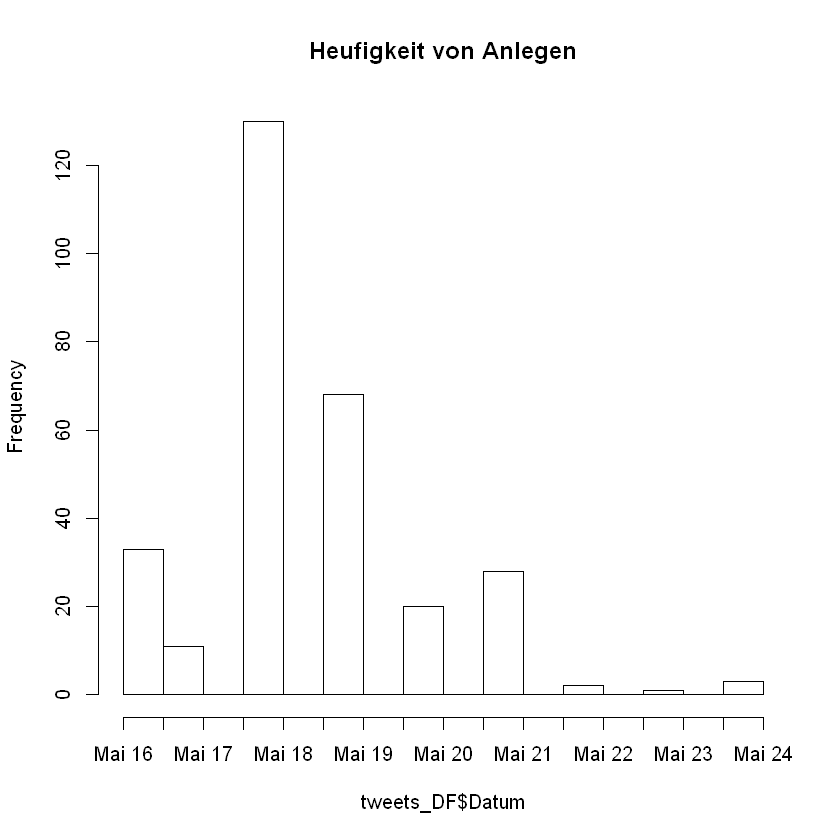

In [15]:
hist(tweets_DF$Datum,breaks=15,freq=TRUE,main="Heufigkeit von Anlegen")

Verktor Ersatz
Diese Verteilung zeigt, dass die Mehrheit der Tweets in dieser Gruppe innerhalb der ersten Sekunden kommt und 
eine viel geringere Anzahl von Tweets in nachfolgenden Zeitintervallen ankommt.
Aus der Verteilung geht hervor, dass die Ankunftszeitverteilung einem Poisson-Verteilungsmuster folgt und es nun möglich ist, 
die Häufigkeit des Auftretens eines Ereignisses in einem bestimmten Zeitintervall zu modellieren.

In [16]:
sorttweetsDF<-tweets_DF[order(as.integer(tweets_DF$Datum)),]
dim(sorttweetsDF) 

[1] 296  17

#### Corupt zu anlegen. Corupt ist collection von Texten

In [ ]:
#Konvertirung myCorpus zu lowercase

In [17]:
myCorpus <- Corpus(VectorSource(sorttweetsDF$text))

In [18]:
myCorpus <- tm_map(myCorpus, content_transformer(tolower))
myCorpus <- tm_map(myCorpus, function(x) iconv(enc2utf8(x), sub = "byte"))

Warning message in tm_map.SimpleCorpus(myCorpus, content_transformer(tolower)):
"transformation drops documents"
Warning message in tm_map.SimpleCorpus(myCorpus, function(x) iconv(enc2utf8(x), :
"transformation drops documents"


In [ ]:
#Löschen Fehler

In [19]:
myCorpus <- tm_map(myCorpus, removePunctuation)

Warning message in tm_map.SimpleCorpus(myCorpus, removePunctuation):
"transformation drops documents"


In [20]:
myCorpus <- tm_map(myCorpus, removeNumbers)

Warning message in tm_map.SimpleCorpus(myCorpus, removeNumbers):
"transformation drops documents"


In [21]:
Textprocessing <- function(x)
{gsub("http[[:alnum:]]*",'', x)
  gsub('http\\S+\\s*', '', x) ## Remove URLs
  gsub('\\b+RT', '', x) ## Remove RT
  gsub('#\\S+', '', x) ## Remove Hashtags
  gsub('@\\S+', '', x) ## Remove Mentions
  gsub('[[:cntrl:]]', '', x) ## Remove Controls and special characters
  gsub("\\d", '', x) ## Remove Controls and special characters
  gsub('[[:punct:]]', '', x) ## Remove Punctuations
  gsub("^[[:space:]]*","",x) ## Remove leading whitespaces
  gsub("[[:space:]]*$","",x) ## Remove trailing whitespaces
  gsub(' +',' ',x) ## Remove extra whitespaces
  gsub("#[A-Za-z0-9]+|@[A-Za-z0-9]+|\\w+(?:\\.\\w+)*/\\S+", "", x)
 }

In [22]:
myCorpus <- tm_map(myCorpus,Textprocessing)

Warning message in tm_map.SimpleCorpus(myCorpus, Textprocessing):
"transformation drops documents"


In [23]:
myCorpus <- tm_map(myCorpus, stripWhitespace)

Warning message in tm_map.SimpleCorpus(myCorpus, stripWhitespace):
"transformation drops documents"


In [ ]:
# Hinzufügen stopwords
# Stopwords sind Wörter , dich nicht segnifikant sind

In [24]:
mystopwords <- c(stopwords("english"),"rt","íí","get","like","just","yes","know","will","good","day","people")

In [ ]:
löschen stopwords

In [25]:
myCorpus <- tm_map(myCorpus,removeWords,mystopwords)

Warning message in tm_map.SimpleCorpus(myCorpus, removeWords, mystopwords):
"transformation drops documents"


In [26]:
myCorpus_copy <- myCorpus

In [27]:
for (i in c(1:2, length(tweets))){
  cat(paste0("[", i, "] "))
  writeLines(strwrap(as.character(myCorpus_copy[[i]]), 60))}

[1] come see teslakidgiga new tesla gigaberlin amazing k drone
footage httpstcovhjpfmjc
[2] gftesla gigaberlin may tesla trains now deliver gravel days
week monday thursday build construction ro
[296] gftesla gigaberlin tesla opponents protest tesla rams
sample piles ground third preliminary building appli


In [28]:
myCorpus <- tm_map(myCorpus, stemCompletion, dictionary=myCorpus_copy)
myCorpus <- Corpus(VectorSource(myCorpus))
myCorpus <- iconv(x = myCorpus,"latin1","UTF-8",sub = "")
myCorpus <- iconv(x = myCorpus,"UTF-16LE", "UTF-8",sub = "")

Warning message in tm_map.SimpleCorpus(myCorpus, stemCompletion, dictionary = myCorpus_copy):
"transformation drops documents"


In [29]:
tdm <- TermDocumentMatrix(myCorpus_copy,control = list(wordlengths = c(1,Inf)))
tdm

<<TermDocumentMatrix (terms: 310, documents: 296)>>
Non-/sparse entries: 3234/88526
Sparsity           : 96%
Maximal term length: 18
Weighting          : term frequency (tf)

In [30]:
#freq.terms <- findFreqTerms(tdm, lowfreq =  50)
freq.terms <- findFreqTerms(tdm)
head(freq.terms,10) 

[1] "amazing"          "come"             "drone"            "footage"         
 [5] "gigaberlin"       "httpstcovhjpfmjc" "new"              "see"             
 [9] "tesla"            "teslakidgiga"

In [31]:
termFreq <- rowSums(as.matrix(tdm))

In [33]:
df <- data.frame(term = names(termFreq), freq = termFreq)

Die Funktion score.sentiment() - ermittelt auf den Wortschätzen , ob ein Word positive oder negative

In [35]:
source( file.path(codeDir, 'sentiment.R') )
tesla.scors = score.sentiment(df$term, pos.words, neg.words, .progress='text')
tesla.scors <- tesla.scors%>%
  filter(!score == 0)

  |======================================================================| 100%


In [36]:
df_1 <- tesla.scors%>%
  left_join(df,c("text" = "term"))

In [37]:
m <- as.matrix(tdm)
m_df <- as.data.frame(m)
m_name <- as.data.frame(t(m))
m_df$text <- colnames(m_name)

In [38]:
df_res <- df_1%>%
  left_join(m_df,by = "text")

Warning message:
"Column `text` joining factor and character vector, coercing into character vector"


In [39]:
df_res$datum <- date() 

In [47]:
df_res

score,text,freq,1,2,3,4,5,6,7,...,289,290,291,292,293,294,295,296,datum,est
<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,amazing,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Sun May 24 15:27:09 2020,Positive
-1,issue,10,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,Sun May 24 15:27:09 2020,Negative
1,protection,10,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,Sun May 24 15:27:09 2020,Positive
1,bright,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Sun May 24 15:27:09 2020,Positive
1,great,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Sun May 24 15:27:09 2020,Positive
1,polished,6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Sun May 24 15:27:09 2020,Positive
1,nice,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Sun May 24 15:27:09 2020,Positive
1,progress,32,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Sun May 24 15:27:09 2020,Positive
-1,slow,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Sun May 24 15:27:09 2020,Negative


Der Grafik zeigt , wir oft ein Wort in Twitter benutzt wird

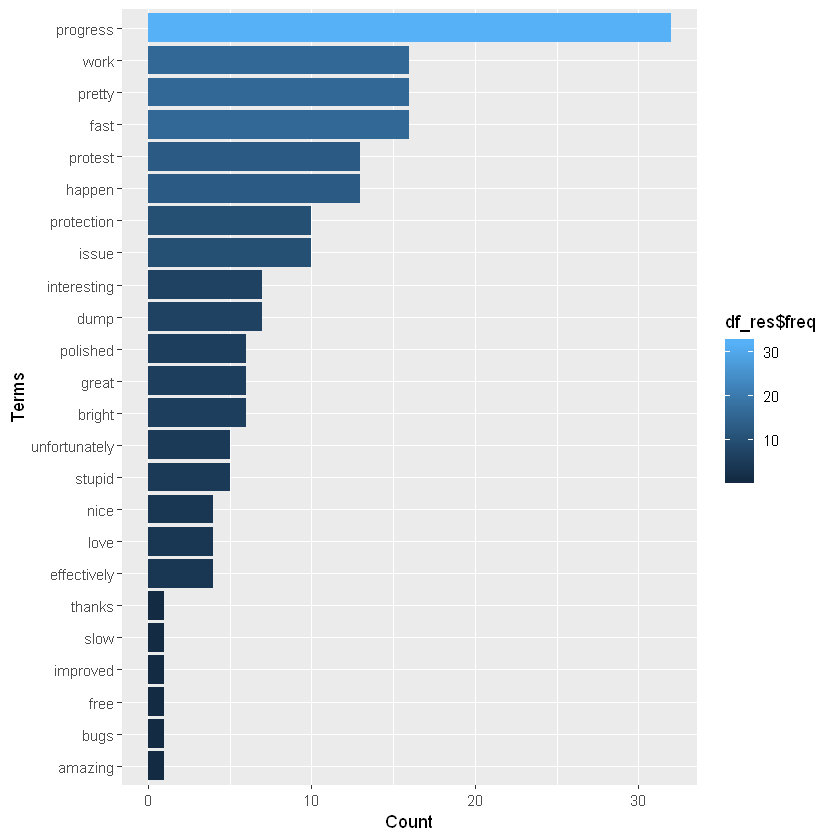

In [40]:
ggplot(df_res,aes(x = reorder(df_res$text, +df_res$freq), y = freq, fill=df_res$freq)) + geom_bar(stat = "identity") +
  scale_colour_gradientn(colors = terrain.colors(10)) + xlab("Terms") + ylab("Count") + coord_flip()

In [ ]:
Der Grafik zeigt Workcloud - Alle Wörter , wie bekomen wurden

In [41]:
des <- df%>%
        left_join(tesla.scors, c("term" = "text"))%>%
         filter(!is.na(score))
wordcloud2(des , color = "random-dark", backgroundColor = "white")

HTML widgets cannot be represented in plain text (need html)

In [ ]:
Der Grafik zeigt Anzahl positiven und negativen Sentimenten 

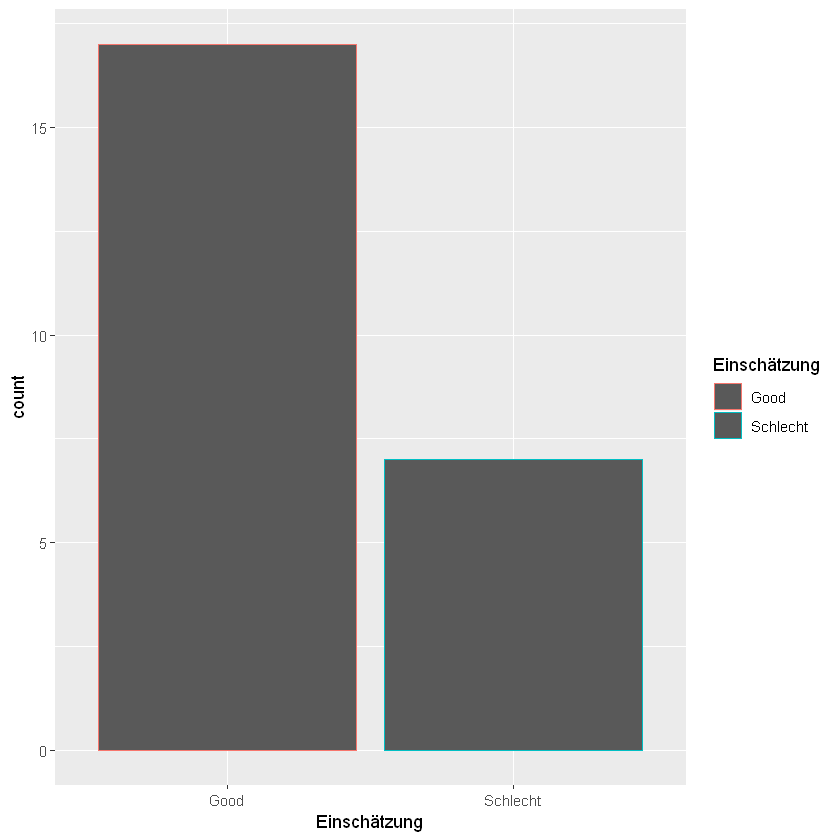

In [42]:
# Ergebnis
df_plot <- select(df_res, score:text)
df_plot$Einschätzung <- ifelse(df_plot$score == 1 ,"Good", "Schlecht")
ggplot(data = df_plot)+
  geom_bar(mapping = aes(x = Einschätzung, color = Einschätzung))

### Logistic Regression

#### Logistische Regression untersuchtden zusammenhang einer binaren Variable und einer mehreren unabhängige Variablen
* Zwei Schritte sind erforderlich:
  + Transformation der linearen Regressionsgleichung auf das Intervall [0;1]  
  + Interpretation der Größe als Wahrscheinlichkeit

Für die Logistische Regression müssen die Daten bearbeitet werden ( Format). Die Daten für eine Perion an der Logistische Regression
teilgenommen (Die Daten für andere Perioden müssen vom Laufwerk geladen werden) 

Vorgehenweise: Aus Twitters der Vergangenheit ein Prognosemodell entwickeln und dieses dann die aktuellen Sentiment Analyse anwenden 
Vorhandene Informationen könnten sein: Positive oder Negative Sentimenten über das Thema "Tesla Gigafactory Berlin-Brandenburg sind 
Die Zielgröße ist : Positive Sentimenten"ja"(1) und Negative "nein" (0)

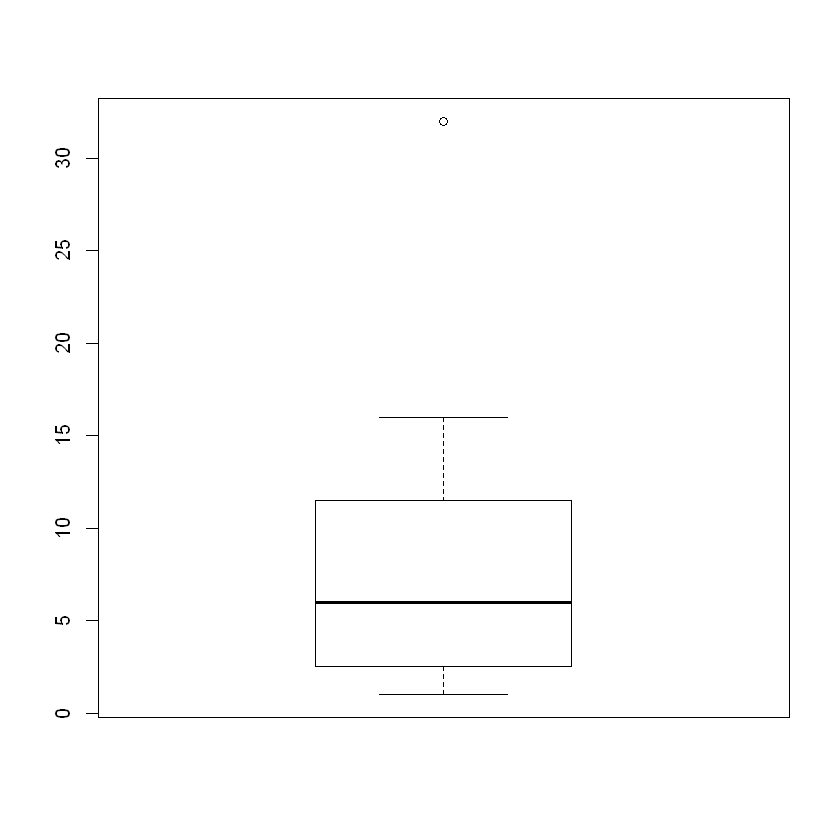

In [58]:
boxplot(df_res$freq)

In [ ]:
#Datebearbeitung

In [44]:
df_res$est <-  ifelse(df_res$score == 1,"Positive","Negative")
lag_df2 <- df_res%>%
  select(score,est,freq)
lag_df2$lag2 <- ( lag_df2$score *  lag_df2$freq ) / sum(lag_df2$freq) 
lag_df2

score,est,freq,lag2
<int>,<chr>,<dbl>,<dbl>
1,Positive,1,0.005376344
-1,Negative,10,-0.053763441
1,Positive,10,0.053763441
1,Positive,6,0.032258065
1,Positive,6,0.032258065
1,Positive,6,0.032258065
1,Positive,4,0.021505376
1,Positive,32,0.172043011
-1,Negative,1,-0.005376344


In [ ]:
# Daten für andere Perioden

In [111]:
lag_cv <- read.csv2('XXXXXXXXXXXXXX')
df_lag <- data.frame(lag_cv)%>%
            select(lag1,heute,direction,volume)%>%
            filter(!is.na(volume))  

In [117]:
df_lag$lag1 <- as.numeric(df_lag$lag1)     
df_lag$heute <- as.numeric(df_lag$heute)  
df_lag$volume <- as.numeric(df_lag$volume)  

In [118]:
df_lag

lag1,heute,direction,volume
<dbl>,<dbl>,<fct>,<dbl>
2,2,Negative,1
2,10,Positive,1
5,13,Positive,10
2,13,Positive,1
3,13,Positive,4
3,8,Positive,4
4,7,Positive,7
6,5,Negative,12
2,11,Positive,1


In [119]:
cor(df_lag[,-3])

,lag1,heute,volume
lag1,1.0000000,-0.0385101,0.7752207
heute,-0.0385101,1.0000000,0.1617251
volume,0.7752207,0.1617251,1.0000000


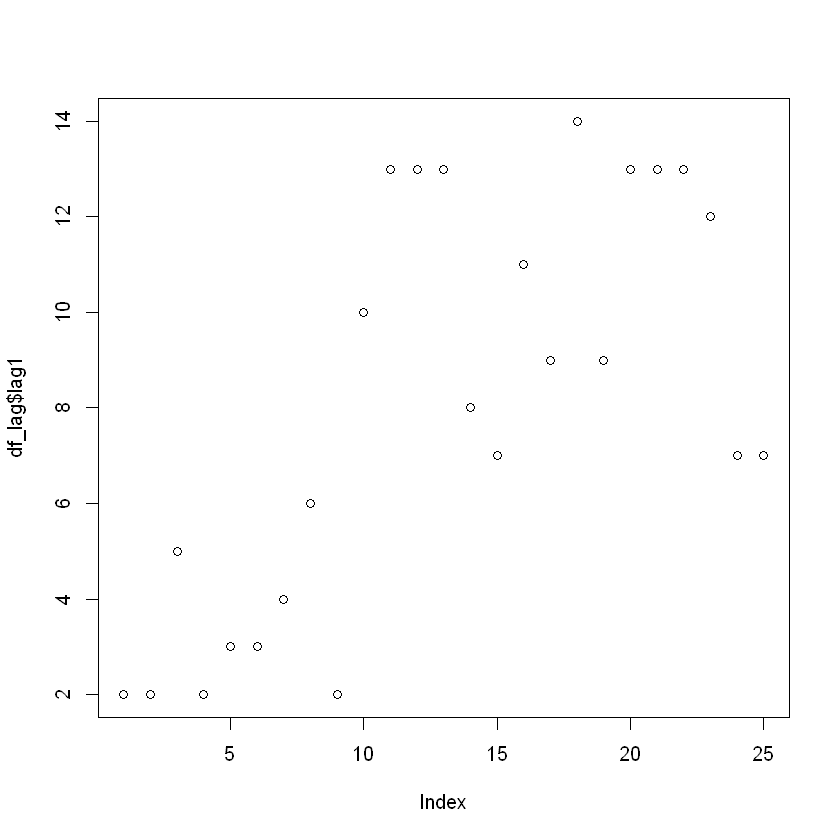

In [121]:
plot(df_lag$lag1)

In [122]:
glm.fits=glm(direction~lag1, data = df_lag, family = binomial)

In [123]:
summary(glm.fits)


Call:
glm(formula = direction ~ lag1, family = binomial, data = df_lag)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6467  -1.4039   0.7886   0.9108   0.9857  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept)  1.15583    0.96392   1.199    0.230
lag1        -0.04905    0.10321  -0.475    0.635

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 31.343  on 24  degrees of freedom
Residual deviance: 31.115  on 23  degrees of freedom
AIC: 35.115

Number of Fisher Scoring iterations: 4


p-Wert ist sehr hoch - 0,635. Das beiweisst dei positive Tendenz inZukunft

In [109]:
coef(glm.fits)

(Intercept)        lag1 
 1.15583209 -0.04904818

In [110]:
summary(glm.fits)$coef

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),1.15583209,0.9639217,1.1990933,0.2304917
lag1,-0.04904818,0.1032110,-0.4752226,0.6346283


In [ ]:
#Die Funktion predict() wird für die Prognose von Varscheinlichkeit benutzt, dass zukunftig positive Sentimenten werden

In [71]:
glm.probs=predict(glm.fits,type="response")

In [75]:
glm.probs[1:10]

1         2         3         4         5         6         7         8 
0.7422576 0.7422576 0.7131211 0.7422576 0.7327632 0.7327632 0.7230496 0.7029829 
        9        10 
0.7422576 0.6604612

In [77]:
contrasts(direction)

,Negative,Positive
,0,0
Negative,1,0
Positive,0,1
